<a href="https://colab.research.google.com/github/LihiShalmon/msc_academic_projects/blob/main/seq2seq_translation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
===============================================================================

**Author**: [Sean Robertson](https://github.com/spro)

This tutorials is part of a three-part series:

-   [NLP From Scratch: Classifying Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
-   [NLP From Scratch: Generating Names with a Character-Level
    RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
-   [NLP From Scratch: Translation with a Sequence to Sequence Network
    and
    Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

This is the third and final tutorial on doing **NLP From Scratch**,
where we write our own classes and functions to preprocess the data to
do our NLP modeling tasks.

In this project we will be teaching a neural network to translate from
French to English.

``` {.sh}
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

\... to varying degrees of success.

This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

![](https://pytorch.org/tutorials/_static/img/seq-seq-images/seq2seq.png)

To improve upon this model we\'ll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-   <https://pytorch.org/> For installation instructions
-   `/beginner/deep_learning_60min_blitz`{.interpreted-text role="doc"}
    to get started with PyTorch in general
-   `/beginner/pytorch_with_examples`{.interpreted-text role="doc"} for
    a wide and deep overview
-   `/beginner/former_torchies_tutorial`{.interpreted-text role="doc"}
    if you are former Lua Torch user

It would also be useful to know about Sequence to Sequence networks and
how they work:

-   [Learning Phrase Representations using RNN Encoder-Decoder for
    Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
-   [Sequence to Sequence Learning with Neural
    Networks](https://arxiv.org/abs/1409.3215)
-   [Neural Machine Translation by Jointly Learning to Align and
    Translate](https://arxiv.org/abs/1409.0473)
-   [A Neural Conversational Model](https://arxiv.org/abs/1506.05869)

You will also find the previous tutorials on
`/intermediate/char_rnn_classification_tutorial`{.interpreted-text
role="doc"} and
`/intermediate/char_rnn_generation_tutorial`{.interpreted-text
role="doc"} helpful as those concepts are very similar to the Encoder
and Decoder models, respectively.

**Requirements**


In [126]:
# 1.a) Upload the ZIP file from your local machine
# from google.colab import files
# uploaded = files.upload()

# Assuming the ZIP file is named "heb-eng.zip"
import zipfile
import os


# 1.b) Parse and clean the heb.txt file
# Read the file
with open('/content/heb.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Clean and parse the file
cleaned_lines = []
for line in lines:
    # Remove leading/trailing whitespace and unwanted characters
    line = line.strip()
    line = re.sub("[^\w\s]","",line)
    if line:  # Ensure line is not empty
        # Split the sentence pair (assuming they are separated by a tab)
        parts = line.split('\t')
        # parts = line.replace("!","").replace(".","")
        if len(parts) >= 2:
            hebrew_sentence = parts[0]
            english_sentence = parts[1]
            # Add cleaned and parsed sentence pair to the list
            cleaned_lines.append((hebrew_sentence, english_sentence))

print(cleaned_lines[:10])
# Optionally, you can write the cleaned data to a new file
with open('/content/data/eng-heb.txt', 'w', encoding='utf-8') as file:
    for hebrew_sentence, english_sentence in cleaned_lines:
        file.write(f'{hebrew_sentence}\t{english_sentence}\n')

print("File parsed and cleaned successfully!")
print(f"cleaned lines are {cleaned_lines[:10]}")

[('Go', 'לך'), ('Hi', 'היי'), ('Hi', 'אהלן'), ('Run', 'רוץ'), ('Run', 'רוצי'), ('Run', 'רוצו'), ('Who', 'מי'), ('Wow', 'וואו'), ('Wow', 'ואו'), ('Duck', 'תתכופפי')]
File parsed and cleaned successfully!
cleaned lines are [('Go', 'לך'), ('Hi', 'היי'), ('Hi', 'אהלן'), ('Run', 'רוץ'), ('Run', 'רוצי'), ('Run', 'רוצו'), ('Who', 'מי'), ('Wow', 'וואו'), ('Wow', 'ואו'), ('Duck', 'תתכופפי')]


In [127]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

[This question on Open Data Stack
Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)
pointed me to the open translation site <https://tatoeba.org/> which has
downloads available at <https://tatoeba.org/eng/downloads> - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: <https://www.manythings.org/anki/>

The English to French pairs are too big to include in the repository, so
download to `data/eng-fra.txt` before continuing. The file is a tab
separated list of translation pairs:

``` {.sh}
I am cold.    J'ai froid.
```

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Download the data from<a href="https://download.pytorch.org/tutorial/data.zip">here</a>and extract it to the current directory.</p>

</div>



In [128]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.


In [156]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF!?]+", r" ", s)  # Keep Hebrew characters
    return s.strip()

In [154]:
import random

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    print(f"initially the lines are {lines[:10]}")
    print('data/%s-%s.txt' % (lang1, lang2))


    # Split every line into pairs and normalize
    print("this is the normalizeString:")
    generator_sample = (normalizeString(s) for l in lines[:10] for s in l.split('\t'))

    for sample in generator_sample:
        print(sample)

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    print(f"sample of pairs {random.sample(pairs,10)}")
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
        print(f"sample of pairs - reversed! {random.sample(pairs, 10)}")
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        print(f"sample of pairs - not reversed! {random.sample(pairs, 10)}")

    return input_lang, output_lang, pairs

In [145]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
   to_return = [pair for pair in pairs if filterPair(pair)]
   print(f"the length is {len(to_return)}")
   return to_return


In [132]:
# from google.colab import drive
# drive.mount('/content/drive')


In [157]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs[:4]:
      print(f"pair at 0 before filter {pair[0]} pair at 1 {pair[1]}")

    pairs = filterPairs(pairs)

    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs[:4]:
      print(f"pair at 0 is {pair[0]} pair at 1 {pair[1]}")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)
print(pairs[:10])
print(random.choice(pairs))


Reading lines...
initially the lines are ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי']
data/eng-heb.txt
this is the normalizeString:
go
לך
hi
היי
hi
אהלן
run
רוץ
run
רוצי
run
רוצו
who
מי
wow
וואו
wow
ואו
duck
תתכופפי
sample of pairs [['the candle burned out', 'הנר אזל וכבה'], ['im in the middle of something can you call me back', 'אני באמצע משהו תוכל להתקשר אליי שוב אחרכך'], ['why do you say things like that', 'למה את אומרת דברים כאלה'], ['is that right', 'זה נכון'], ['tom had a very good night', 'לתום היה לילה טוב מאד'], ['turn on the radio please', 'תדליקי את הרדיו בבקשה'], ['ill have a talk with tom', 'אצטרך לדבר עם תום'], ['these flowers bloom earlier than others do', 'הפרחים האלה פורחים מוקדם יותר מהאחרים'], ['i watched it on youtube', 'צפיתי בזה באתר יוטיוב'], ['i dont want to talk to tom', 'אני לא מעוניינת לדבר עם תום']]
sample of pairs - reversed! [['כמה זה בדולרים', 'how much is it in dollars'], ['כ

In [159]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [160]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [161]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [162]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [163]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [164]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [165]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [166]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [167]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [174]:
def evaluateRandomly(encoder, decoder, n=20, return_sentences=False):
    return_senetences = []
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        return_senetences.append((pair[0], pair[1], output_sentence))
    if return_sentences:
        return return_senetences

In [169]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
initially the lines are ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי']
data/eng-heb.txt
this is the normalizeString:
go
לך
hi
היי
hi
אהלן
run
רוץ
run
רוצי
run
רוצו
who
מי
wow
וואו
wow
ואו
duck
תתכופפי
sample of pairs [['a freezing beggar was brought into the hospital for treatment however he didnt have even one cent with which to settle the bill', 'קבצן קפוא הובא לבית החולים לטיפול אבל לא היה לו גרוש כדי לשלם את החשבון'], ['the richer he became the more he wanted', 'ככל שהוא נהיה יותר עשיר הוא רצה עוד יותר'], ['monica sone was a japaneseamerican writer', 'מוניקה סונה הייתה סופרת יפנית אמריקנית'], ['it wasnt that big a deal', 'זה לא היה ענין כל כך גדול'], ['the wrestler weighs over kilograms', 'משקלו של המתאבק הזה מעל קג'], ['tom appears to be nervous', 'תום נראה עצבני'], ['he asked for a beer', 'הוא ביקש בירה'], ['maybe were doing this all backwards', 'אולי אנו עושים את כל זה הפוך'], ['will y

Set dropout layers to `eval` mode


In [173]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> אני אוכל תפוח
= i am eating an apple
< i am eating an apple <EOS>

> אני מוכן ומזומן
= i am ready
< i am ready <EOS>

> היא צעירה ממני
= she is younger than me
< she is younger than me younger clerk me <EOS>

> אתה נמצא במקום בטוח
= you are in a safe place
< you are in a safe place <EOS>

> אני כל כך עייף שאני לא יכול ללמוד
= i am so tired that i cant study
< i am so tired that i cant study <EOS>

> הוא בערך בגילי
= he is about my age
< he is about my age <EOS>

> את תמיד מתלוננת
= you are always complaining
< you are always complaining me <EOS>

> אני שמח שנתקלתי בך כאן
= i am glad to run into you here
< i am glad to run into here here <EOS>

> אני עייף מלהקשיב לטום
= i am tired of listening to tom
< i am tired of listening to tom here <EOS>

> היא יפהפיה
= she is beautiful
< she is beautiful <EOS>

> הוא לא שם
= he is not there
< he is not there <EOS>

> היא באמת גברת צעירה מקסימה ביותר
= she is a most charming young lady indeed
< she is a most charming young lady indeed <EOS>

> ה

In [189]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_senetences = []
    for i in range(n):
        pair = random.choice(pairs)
        output_words, attention_scores= evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        return_senetences.append((pair[0], pair[1], output_sentence))
        print(pair)
        print(output_sentence)
        print(attention_scores)
        # showAttention(pair[1], pair[2], attention_scores)
    if return_sentences:
        return return_senetences

evaluateRandomly_and_plot(encoder, decoder, n=5, return_sentences=False)


['היא משוכנעת בתמימותי', 'she is convinced of my innocence']
she is convinced of my innocence <EOS>
tensor([[[1.3007e-06, 2.4559e-01, 1.8355e-01, 5.7086e-01],
         [2.8096e-06, 2.1214e-01, 4.1442e-01, 3.7344e-01],
         [2.1533e-05, 8.3570e-02, 8.0420e-01, 1.1221e-01],
         [6.7287e-05, 6.1770e-02, 2.0128e-01, 7.3689e-01],
         [1.1249e-04, 8.5987e-02, 3.0977e-01, 6.0413e-01],
         [4.8531e-05, 1.2115e-01, 2.9980e-01, 5.7900e-01],
         [4.7864e-06, 1.6770e-01, 1.8862e-01, 6.4368e-01],
         [1.3000e-04, 1.6745e-01, 1.3983e-01, 6.9259e-01],
         [6.0916e-06, 1.1805e-01, 4.6139e-02, 8.3581e-01],
         [3.1090e-06, 1.2658e-01, 7.8656e-02, 7.9476e-01]]], device='cuda:0')
['היא עקשנית', 'she is stubborn']
she is obstinate <EOS>
tensor([[[1.1289e-05, 3.2839e-03, 9.9670e-01],
         [2.1570e-05, 2.9974e-03, 9.9698e-01],
         [5.3559e-04, 5.3517e-02, 9.4595e-01],
         [1.0786e-04, 2.2409e-03, 9.9765e-01],
         [7.0379e-05, 1.0441e-03, 9.9889e-01],

In [223]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
from IPython.display import display  # Explicitly import display for Colab
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze(0).cpu().numpy()  # Remove batch dimension

    # Ensure input_tokens and output_tokens match attention dimensions
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words
    min_length = min(len(output_words), len(input_tokens))
    input_tokens = input_tokens[:min_length]
    output_tokens = output_tokens[:min_length]

    # Ensure output_tokens contains '<EOS
    # if output_tokens != ['<EOS>']:
    #     output_tokens.append('<EOS>')

    if attentions.shape != (len(output_tokens), len(input_tokens)):
        print(f"Warning: Mismatch in attention shape {attentions.shape} vs. input ({len(input_tokens)}) & output ({len(output_tokens)}) tokens")
        return  # Avoid crashing

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes correctly
    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens[::-1], rotation=90)

    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens)

    # Improve layout
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('Input Sentence (Hebrew)')
    plt.ylabel('Output Sentence (English)')
    plt.title('Attention Heatmap')
    plt.show()
    display(fig)  # <-- This is needed for Google Colab
    plt.close(fig)  # <-- Prevents duplicate empty figures in Colab


def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_sentences = []

    for i in range(n):
        pair = random.choice(pairs)  # Select a random sentence pair
        input_sentence = pair[0]  # Hebrew input
        target_sentence = pair[1]  # Target English sentence

        output_words, attention_scores = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        return_sentences.append((input_sentence, target_sentence, output_sentence))

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Output: {output_sentence}")
        print(f"Attention Shape: {attention_scores.shape}")  # Debugging

        showAttention(target_sentence,output_words ,attention_scores)  # Fix argument order

    if return_sentences:
        return return_sentences

# Run with n=1 sample
evaluateRandomly_and_plot(encoder, decoder, n=10, return_sentences=False)


Input: הוא נעדר בשל מחלתו
Target: he is absent because of illness
Output: he is absent because of his books absent from school
Attention Shape: torch.Size([1, 10, 5])
Input: היא השליח
Target: she is the messenger
Output: she is the messenger <EOS>
Attention Shape: torch.Size([1, 10, 3])
Input: את תמיד מתלוננת
Target: you are always complaining
Output: you are always complaining me <EOS>
Attention Shape: torch.Size([1, 10, 4])
Input: היא תמיד עסוקה
Target: she is always busy
Output: she is always busy cooking now <EOS>
Attention Shape: torch.Size([1, 10, 4])
Input: היא בדיאטה
Target: she is on a diet
Output: she is on a diet <EOS>
Attention Shape: torch.Size([1, 10, 3])
Input: אתה לבן כמו סיד
Target: you are as white as a sheet
Output: you are as white as white as white as white
Attention Shape: torch.Size([1, 10, 5])
Input: אני יכול לקרוא אנגלית
Target: i am able to read english
Output: i am familiar next year year next year next year
Attention Shape: torch.Size([1, 10, 5])
Input: אנחנ

[('הוא נעדר בשל מחלתו',
  'he is absent because of illness',
  'he is absent because of his books absent from school'),
 ('היא השליח', 'she is the messenger', 'she is the messenger <EOS>'),
 ('את תמיד מתלוננת',
  'you are always complaining',
  'you are always complaining me <EOS>'),
 ('היא תמיד עסוקה',
  'she is always busy',
  'she is always busy cooking now <EOS>'),
 ('היא בדיאטה', 'she is on a diet', 'she is on a diet <EOS>'),
 ('אתה לבן כמו סיד',
  'you are as white as a sheet',
  'you are as white as white as white as white'),
 ('אני יכול לקרוא אנגלית',
  'i am able to read english',
  'i am familiar next year year next year next year'),
 ('אנחנו הבנים שלו',
  'we are his sons',
  'he is his his sons love by his employees his'),
 ('אני חובבת מוסיקה', 'i am fond of music', 'i am fond of music <EOS>'),
 ('אני התובע במשפט ההוא',
  'i am the plaintiff in that trial',
  'i am the plaintiff in that trial that trial that')]

Input: הביקורת שלו גומזת
Target: he is a harsh critic
Output: he is a harsh critic man <EOS>
Attention Shape: torch.Size([1, 10, 4])


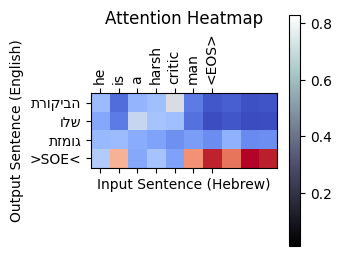

Input: היא מפורסמת
Target: she is widely known
Output: she is widely known <EOS>
Attention Shape: torch.Size([1, 10, 3])


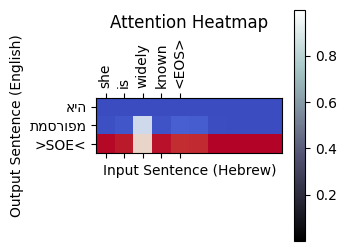

Input: היא ילדה ותו לא
Target: she is a mere child
Output: she is a mere child <EOS>
Attention Shape: torch.Size([1, 10, 5])


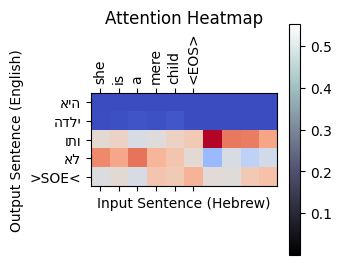

Input: הם מרוצים מהחוזה
Target: they are satisfied with the contract
Output: they are satisfied with the contract number me for payment
Attention Shape: torch.Size([1, 10, 4])


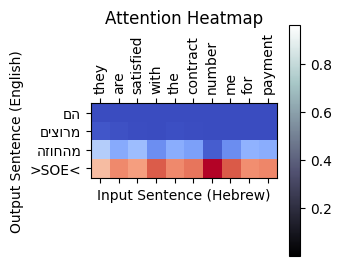

Input: היא לא שם
Target: she isnt there
Output: she isnt there <EOS>
Attention Shape: torch.Size([1, 10, 4])


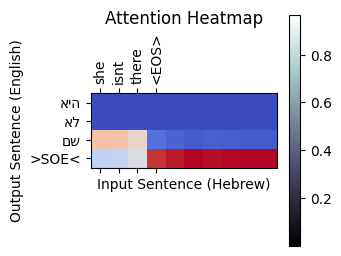

[('הביקורת שלו גומזת',
  'he is a harsh critic',
  'he is a harsh critic man <EOS>'),
 ('היא מפורסמת', 'she is widely known', 'she is widely known <EOS>'),
 ('היא ילדה ותו לא', 'she is a mere child', 'she is a mere child <EOS>'),
 ('הם מרוצים מהחוזה',
  'they are satisfied with the contract',
  'they are satisfied with the contract number me for payment'),
 ('היא לא שם', 'she isnt there', 'she isnt there <EOS>')]

In [238]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import numpy as np
import random
from IPython.display import display  # Explicitly import display for Colab

def showAttention(input_sentence, output_words, attentions):
    attentions = attentions.squeeze(0).cpu().numpy()  # Remove batch dimension

    # Ensure input_tokens and output_tokens match attention dimensions
    input_tokens = input_sentence.split(' ') + ['<EOS>']
    output_tokens = output_words  # Use predicted output, not the target

    # Verify and adjust lengths to match attention matrix
    expected_input_len = attentions.shape[1]
    expected_output_len = attentions.shape[0]

    # if len(input_tokens) != expected_input_len:
    #     print(f"Adjusting input tokens from {len(input_tokens)} to {expected_input_len}")
    #     input_tokens = input_tokens[:expected_input_len]

    # if len(output_tokens) != expected_output_len:
    #     print(f"Adjusting output tokens from {len(output_tokens)} to {expected_output_len}")
    #     output_tokens = output_tokens[:expected_output_len]

    # if attentions.shape != (len(output_tokens), len(input_tokens)):
    #     print(f"Error: Final mismatch in attention shape {attentions.shape} vs. input ({len(input_tokens)}) & output ({len(output_tokens)}) tokens")
    #     return  # Avoid crashing

    fig, ax = plt.subplots(figsize=(3, 3))
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Transpose the attention matrix for correct orientation
    cax = ax.matshow(attentions.T, cmap='coolwarm')

    # Set tick positions correctly
    ax.set_xticks(range(len(output_tokens)))
    ax.set_xticklabels(output_tokens, rotation=90, ha='center')  # English output on x-axis

    ax.set_yticks(range(len(input_tokens)))
    ax.set_yticklabels([word[::-1] for word in input_tokens])  # Hebrew input (right-to-left)

    # Ensure only 1 set of ticks is applied
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(output_tokens))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(input_tokens))))

    plt.xlabel('Output Sentence (English)')
    plt.ylabel('Input Sentence (Hebrew)')

    # # Set up axes correctly
    # ax.set_xticks(range(len(input_tokens)))
    # ax.set_xticklabels(input_tokens, rotation=90)

    # ax.set_yticks(range(len(output_tokens)))
    # ax.set_yticklabels(output_tokens)

    # # Improve layout
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    # input_ticks= [word[::-1] for word in input_tokens ]
    # ax.set_xticklabels(input_ticks, rotation=90, ) #ha='left')

    # # Set color map to 'coolwarm' for better contrast
    # cax = ax.matshow(attentions, cmap='coolwarm')
    plt.xlabel('Input Sentence (Hebrew)')
    plt.ylabel('Output Sentence (English)')
    plt.title('Attention Heatmap')


    display(fig)  # Explicitly display in Google Colab
    # plt.show()
    plt.close(fig)  # Prevent duplicate figures


def evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False):
    return_sentences = []

    for i in range(n):
        pair = random.choice(pairs)  # Select a random sentence pair
        input_sentence = pair[0]  # Hebrew input
        target_sentence = pair[1]  # Target English sentence

        output_words, attention_scores = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
        output_sentence = ' '.join(output_words)

        return_sentences.append((input_sentence, target_sentence, output_sentence))

        print(f"Input: {input_sentence}")
        print(f"Target: {target_sentence}")
        print(f"Output: {output_sentence}")
        print(f"Attention Shape: {attention_scores.shape}")  # Debugging

        showAttention(input_sentence, output_words, attention_scores)  # Fix argument order

    if return_sentences:
        return return_sentences

# Run with n=1 sample
evaluateRandomly_and_plot(encoder, decoder, n=5, return_sentences=False)


In [209]:
evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False)


Input: אני הולך
Target: i am going
Output: i am all <EOS>
Attention Shape: torch.Size([1, 10, 3])


[('אני הולך', 'i am going', 'i am all <EOS>')]

In [197]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch


evaluateRandomly_and_plot(encoder, decoder, n=1, return_sentences=False)


Input: אין לנו זמן רב תום
Target: we are short of time tom
Output: we are short of time tom <EOS>
Attention Shape: torch.Size([1, 10, 6])


## changes:


Reading lines...
initially the lines are ['Go\tלך', 'Hi\tהיי', 'Hi\tאהלן', 'Run\tרוץ', 'Run\tרוצי', 'Run\tרוצו', 'Who\tמי', 'Wow\tוואו', 'Wow\tואו', 'Duck\tתתכופפי']
data/eng-heb.txt
this is the normalizeString:
go
לך
hi
היי
hi
אהלן
run
רוץ
run
רוצי
run
רוצו
who
מי
wow
וואו
wow
ואו
duck
תתכופפי
sample of pairs [['she cant have written it herself', 'לא ייתכן שהיא כתבה זאת בעצמה'], ['i was deeply impressed by roman architecture', 'התרשמתי עמוקות מהארכיטקטורה הרומאית'], ['it is impossible to put the plan into practice', 'אי אפשר לממש את התכנית'], ['listen carefully to what im going to tell you', 'הקשב היטב למה שאגיד לך'], ['i dont care what she eats', 'לא איכפת לי מה היא אוכלת'], ['he was born dumb', 'הוא נולד אילם'], ['tom is laughing at mary', 'תום צוחק על מרי'], ['whats your favorite way to cook beans', 'מה הדרך בה אתה מעדיף לבשל שעועית'], ['i keep a diary in english', 'אני מנהל יומן באנגלית'], ['to the best of my knowledge no', 'למיטב ידיעתי לא']]
sample of pairs - reversed! [['תן לי 

<Figure size 640x480 with 0 Axes>

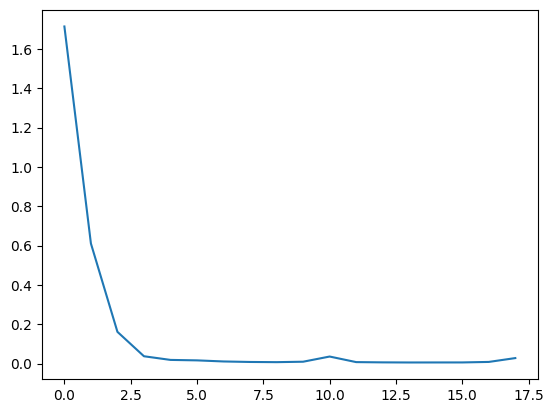

In [239]:
hidden_size = 248
batch_size = 16

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 90, print_every=5, plot_every=5)